In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.model import LSTMGenerator, UnitaryLSTMGenerator, UnitaryLSTMRegressor
from Path_Char.utils import AddTime
from torch.utils.data import DataLoader
import ml_collections
import seaborn as sns
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
sns.set()
torch.manual_seed(0)
device = 'cuda'

In [2]:
config = {'G_input_dim': 3,
          'G_hidden_dim': 32,
          'G_num_layers': 2,
          'G_output_dim': 5}
config = ml_collections.ConfigDict(config)

In [3]:
# data = pickle.load(open('./data_optimal_stopping.obj','rb'))
# prices, paths = data['prices'], data['paths']

data = torch.load('./examples/Rough/train_X.pt')

In [25]:
data.shape

torch.Size([16000, 50, 3])

In [4]:
N, L, D = data.shape
lie_degree_1 = 5
num_samples_1 = 10
add_time = True

pcf_level_1 = char_func_path(num_samples=num_samples_1, 
                              hidden_size=lie_degree_1, 
                              input_dim=D, 
                              add_time=add_time, 
                              include_initial = False,
                              return_sequence=False)
pcf_level_1.to(device)
data = AddTime(data).to(device)

In [26]:
with torch.no_grad():
    dev_X = pcf_level_1.unitary_development(data.to(device)).unsqueeze(1).repeat([1, 50, 1, 1, 1])
    
train_X_dl = DataLoader(data, 256, shuffle=True)
train_X_dev_dl = DataLoader(dev_X, 256, shuffle=True)

# train_X_n_dl = DataLoader(X_n, 128, shuffle=True)
# train_X_n_dev_dl = DataLoader(dev_X_n, 128, shuffle=True)

In [27]:
dev_X.shape

torch.Size([16000, 50, 10, 5, 5])

In [28]:
regressor_for_X = UnitaryLSTMRegressor(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_linear_maps=num_samples_1,
        n_layers=config.G_num_layers
    )
regressor_for_X.to(device)

UnitaryLSTMRegressor(
  (rnns): ModuleList(
    (0): LSTM(3, 32, num_layers=2, batch_first=True)
    (1): LSTM(3, 32, num_layers=2, batch_first=True)
    (2): LSTM(3, 32, num_layers=2, batch_first=True)
    (3): LSTM(3, 32, num_layers=2, batch_first=True)
    (4): LSTM(3, 32, num_layers=2, batch_first=True)
    (5): LSTM(3, 32, num_layers=2, batch_first=True)
    (6): LSTM(3, 32, num_layers=2, batch_first=True)
    (7): LSTM(3, 32, num_layers=2, batch_first=True)
    (8): LSTM(3, 32, num_layers=2, batch_first=True)
    (9): LSTM(3, 32, num_layers=2, batch_first=True)
  )
  (linears): ModuleList(
    (0): Linear(in_features=32, out_features=50, bias=False)
    (1): Linear(in_features=32, out_features=50, bias=False)
    (2): Linear(in_features=32, out_features=50, bias=False)
    (3): Linear(in_features=32, out_features=50, bias=False)
    (4): Linear(in_features=32, out_features=50, bias=False)
    (5): Linear(in_features=32, out_features=50, bias=False)
    (6): Linear(in_features=32,

In [54]:
def train_regressor(regressor, iterations, X_dl, Y_dl):
    loss = []
    best_loss = 10000.
    regressor_optimizer = torch.optim.Adam(regressor.parameters(), betas=(0, 0.9), lr=0.002)
    regressor.train()
    for i in tqdm(range(iterations)):
        regressor_optimizer.zero_grad()
        batch_X = next(iter(X_dl))
        batch_X_dev = next(iter(Y_dl))
        reg_dev = regressor(batch_X, device)
    #     print(batch_Y.shape, reg_dev.shape)
        regressor_loss = torch.norm(reg_dev - batch_X_dev)
        if regressor_loss < best_loss:
            print("Loss updated: {}".format(regressor_loss), " at iteration {}".format(i))
#             with torch.no_grad():
#                 print(torch.norm(reg_dev - batch_X_dev, dim = [2,3]).mean(0))
            best_loss = regressor_loss
            trained_regressor = regressor
        loss.append(regressor_loss)
        regressor_loss.backward()
        regressor_optimizer.step()
    
    return trained_regressor, loss

In [29]:
trained_regressor_X, losses = train_regressor(regressor_for_X, 10000, train_X_dl, train_X_dev_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 362.472412109375  at iteration 0
Loss updated: 354.776611328125  at iteration 1
Loss updated: 343.5869140625  at iteration 2
Loss updated: 331.4811706542969  at iteration 3
Loss updated: 318.2199401855469  at iteration 4
Loss updated: 298.0776672363281  at iteration 5
Loss updated: 279.025634765625  at iteration 6
Loss updated: 256.4327087402344  at iteration 7
Loss updated: 237.72837829589844  at iteration 8
Loss updated: 216.2695770263672  at iteration 9
Loss updated: 195.53028869628906  at iteration 10
Loss updated: 176.818603515625  at iteration 11
Loss updated: 164.20840454101562  at iteration 12
Loss updated: 159.03135681152344  at iteration 13
Loss updated: 145.41249084472656  at iteration 14
Loss updated: 137.17465209960938  at iteration 15
Loss updated: 136.65980529785156  at iteration 17
Loss updated: 135.7979736328125  at iteration 18
Loss updated: 123.58457946777344  at iteration 19
Loss updated: 122.83892822265625  at iteration 23
Loss updated: 119.2340698242

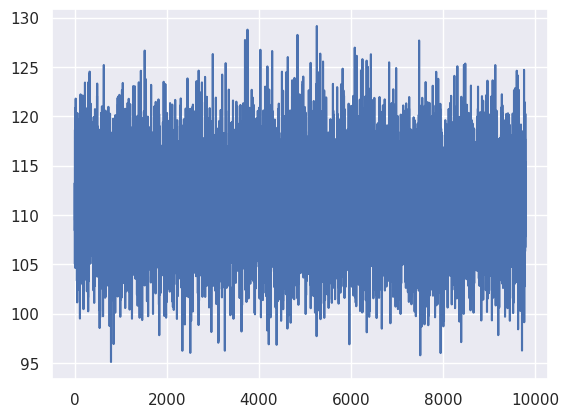

In [34]:
plt.plot(torch.stack(losses).detach().cpu()[200:])

In [29]:
with torch.no_grad():
    batch_X = next(iter(train_X_dl))
    batch_X_dev = next(iter(train_X_dev_dl))
    reg_dev = regressor_for_X(batch_X, 1,device)
    print(reg_dev.shape, batch_X_dev.shape)
    regressor_loss = reg_dev - batch_X_dev[]

torch.Size([256, 50, 5, 5]) torch.Size([256, 50, 10, 5, 5])


RuntimeError: The size of tensor a (50) must match the size of tensor b (10) at non-singleton dimension 2

In [41]:
regressor_loss.shape

torch.Size([256, 50, 5, 5])

In [50]:
(torch.norm(regressor_loss, dim=(2,3))/torch.norm(reg_dev, dim=(2,3))).mean()

tensor(0.3863, device='cuda:0')

In [ ]:
class high_order_PCFGAN_trainer():
    def __init__(self, G, regressor_X, lie_degree_1, lie_degree_2, add_time = True, device = 'cuda'):
        super(high_order_PCFGAN_trainer, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.device = device
        self.regressor_X = regressor_X
        self.regressor_X.to(device)

        self.G = G
        self.G.to(device)
        self.lie_degree_1 = lie_degree_1
        self.add_time = add_time
        self.num_samples_2 = 10
        self.lie_degree_2 = 5
        self.pcf_level_2 = char_func_path(num_samples=self.num_samples_2, 
                                      hidden_size=self.lie_degree_2, 
                                      input_dim=2*self.lie_degree_1**2, 
                                      add_time=add_time, 
                                      include_initial = False,
                                      return_sequence=False)
        self.pcf_level_2.to(device)
        
    
    def train_M(self, X_dl, X_n_dl):
        iterations = 10000
        best_loss = 0.
        
        char_2_optimizer = torch.optim.Adam(self.pcf_level_2.parameters(), betas=(0, 0.9), lr=0.002)
        
        print('start opitmize charateristics function')
        self.regressor_X.eval()
        self.regressor_X_n.eval()
        self.pcf_level_2.train()
        for i in tqdm(range(iterations)):
            
            X = next(iter(X_dl))
            X_n = next(iter(X_n_dl))
            with torch.no_grad():
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_Y = self.regressor_X_n(X_n, self.device).reshape([-1, X_n.shape[1], self.lie_degree_1**2])
                
                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)

            char_2_optimizer.zero_grad()
            char_loss = - self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
            if -char_loss > best_loss:
                print("Loss updated: {}".format(-char_loss))
                best_loss = -char_loss
            if i%100 == 0:
                print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
            char_loss.backward()
            char_2_optimizer.step()
    
    def evaluate(self, X_dl, X_n_dl):
        self.pcf_level_2.eval()
        self.regressor_X.eval()
        self.regressor_X_n.eval()
        repeats = 100
        MMD_1 = np.zeros((repeats))
        MMD_2 = np.zeros((repeats))
        with torch.no_grad():
            for i in tqdm(range(repeats)):
                X = next(iter(X_dl))
                X_n = next(iter(X_n_dl))
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_X_ = self.regressor_X(X_, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_Y = self.regressor_X_n(X_n, self.device).reshape([-1, X_n.shape[1], self.lie_degree_1**2])

                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)
                exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag],-1)
                
                MMD_1[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
                MMD_2[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
        return MMD_1, MMD_2